In [1]:
import pandas as pd

from astroquery.esa.euclid.core import EuclidClass, Euclid
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from multiprocessing.pool import ThreadPool
from astropy import wcs
from astropy.io import fits
import numpy as np
import pandas as pd
#import sep
import glob
import os

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.table import Table
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)
pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)

/tmp/ipykernel_1137/368564059.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [56]:
df = pd.read_csv('/media/home/my_workspace/repos/bulk-euclid-cutouts/notebooks/DESI_above_180.csv', usecols=['TARGET_RA', 'TARGET_DEC'])

In [63]:
sdss = pd.read_csv('/media/home/my_workspace/repos/bulk-euclid-cutouts/notebooks/zoo2MainSpecz.csv')


In [33]:
# change to your username
Euclid.login(user='mwalms01')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]


Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


In [34]:
query_str = """
            SELECT right_ascension, declination
            FROM catalogue.mer_catalogue
            WHERE segmentation_area > 10000
            ORDER BY segmentation_area DESC
            """
job = Euclid.launch_job_async(query_str, background=False)
len(job.results)

INFO: Query finished. [astroquery.utils.tap.core]


287151

In [ ]:
rand_fraction = 0.01

query_str = f"""
            SELECT right_ascension, declination, segmentation_area, flux_segmentation, object_id, spurious_prob, vis_det, det_quality_flag, flag_vis, flag_y
            FROM catalogue.mer_catalogue
            WHERE segmentation_area > 100
            AND gaia_id IS NULL
            AND vis_det=1
            AND spurious_prob < 0.2
            AND RAND() < {rand_fraction}
            """
job = Euclid.launch_job_async(query_str, background=False, dump_to_file=True, output_file='latest_mer_catalogue.csv', output_format='csv')

In [5]:
mer = pd.read_csv('latest_mer_catalogue.csv')

In [11]:
len(mer)

180353

In [12]:
# df = df.sample(100000)

In [13]:
from astropy.coordinates import SkyCoord
from astropy import units

In [57]:
df['ra'] = df['TARGET_RA']
df['dec'] = df['TARGET_DEC']

mer['ra'] = mer['right_ascension']
mer['dec'] = mer['declination']

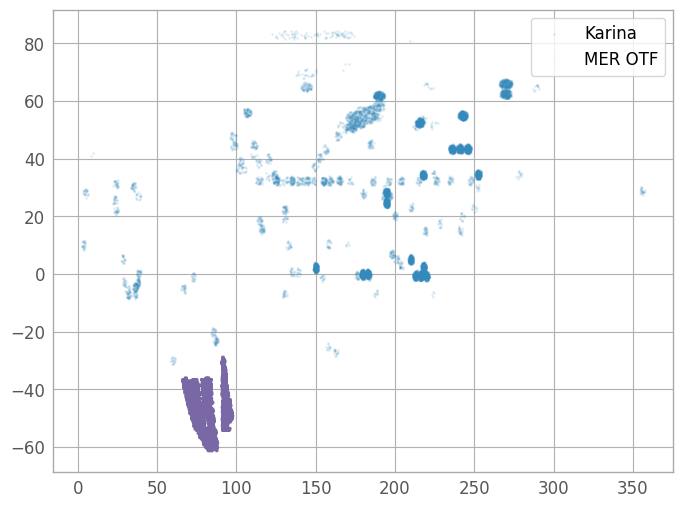

In [31]:
plt.scatter(df['ra'], df['dec'], label='Karina', alpha=.1, s=1.)
plt.scatter(mer['ra'], mer['dec'], label='MER OTF', alpha=.01, s=1.)
plt.legend()

In [37]:
query_str = """SELECT * FROM sedm.mosaic_product 
    WHERE (product_type='DpdMerBksMosaic')
    AND (filter_name='VIS')
"""
job = Euclid.launch_job_async(query_str, verbose=False, background=False) 
tiles = job.results.to_pandas()# [['release_name', 'instrument_name']].value_counts()

INFO: Query finished. [astroquery.utils.tap.core]


In [39]:
tiles.columns.values

array(['category', 'checksum', 'creation_date', 'crpix1', 'crpix2',
       'crval1', 'crval2', 'data_release_oid', 'data_size', 'dec',
       'file_name', 'file_path', 'filter_name', 'first_type', 'fov',
       'instrument_name', 'mosaic_product_oid', 'product_id',
       'product_type', 'provenance_id', 'published', 'ra', 'release_date',
       'release_name', 'second_type', 'stc_s', 'technique', 'tile_index',
       'to_be_published', 'zero_point', 'zero_point_error'], dtype=object)

In [42]:
tiles['release_name'].value_counts()

release_name
F-006                 1916
CALBLOCK_PV-005_R3    276 
F-003_240612          113 
F-003_240321          101 
CALBLOCK_PV-005_R2    22  
Name: count, dtype: int64

In [45]:
tiles = tiles[tiles['release_name'].str.startswith('F')]

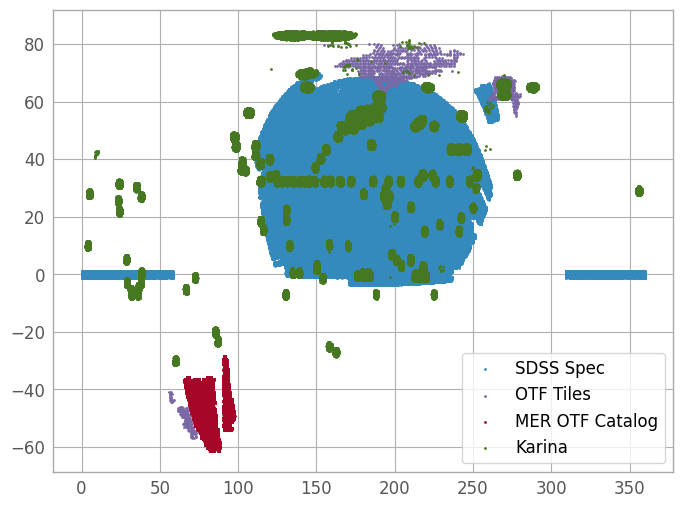

In [67]:
# tiles[['ra', 'dec']]
plt.scatter(sdss['ra'], sdss['dec'], label='SDSS Spec', alpha=1, s=1.)
plt.scatter(tiles['ra'], tiles['dec'], label='OTF Tiles', s=1.)
plt.scatter(mer['ra'], mer['dec'], label='MER OTF Catalog', alpha=1, s=1.)
plt.scatter(df['ra'], df['dec'], label='Karina', alpha=1, s=1.)

plt.legend()



(50.0, 70.0)

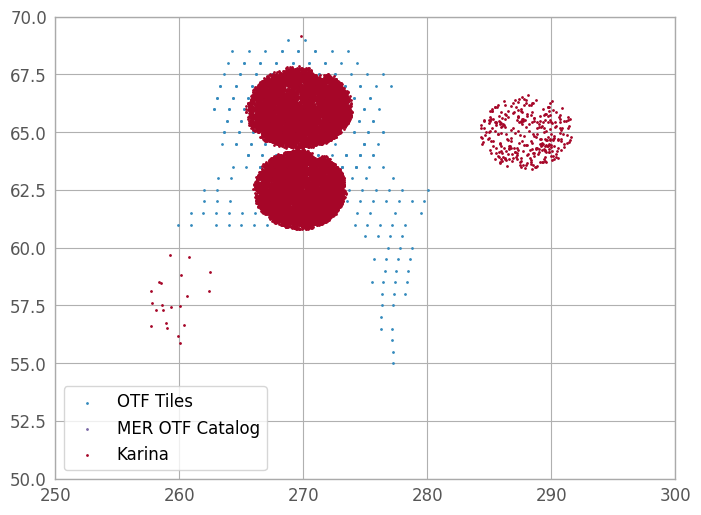

In [58]:
plt.scatter(tiles['ra'], tiles['dec'], label='OTF Tiles', s=1.)
plt.scatter(mer['ra'], mer['dec'], label='MER OTF Catalog', alpha=1, s=1.)
plt.scatter(df['ra'], df['dec'], label='Karina', alpha=1, s=1.)
plt.legend()
plt.xlim([250, 300])
plt.ylim([50, 70])

(50.0, 70.0)

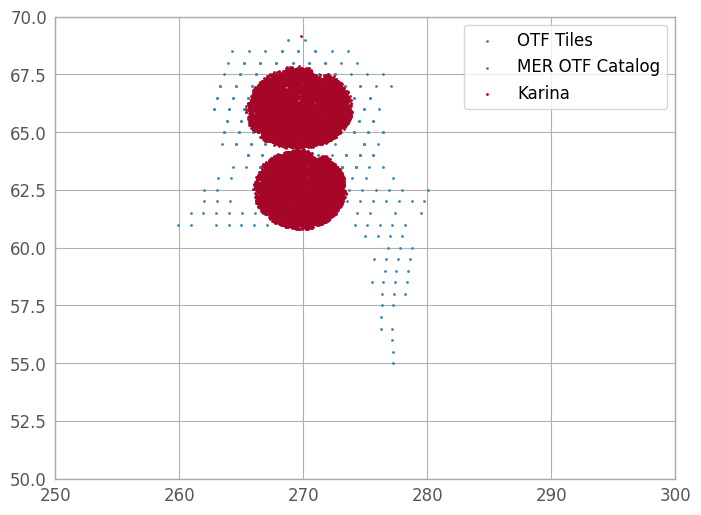

In [61]:
df_edfn = df[(df['ra'] > 260) & (df['ra'] < 280) & (df['dec'] > 60) & (df['dec'] < 70)]

plt.scatter(tiles['ra'], tiles['dec'], label='OTF Tiles', s=1.)
plt.scatter(mer['ra'], mer['dec'], label='MER OTF Catalog', alpha=1, s=1.)
plt.scatter(df_edfn['ra'], df_edfn['dec'], label='Karina', alpha=1, s=1.)
plt.legend()
plt.xlim([250, 300])
plt.ylim([50, 70])

In [62]:
len(df_edfn)

17142

In [ ]:
# tiles[['ra', 'dec']]
plt.scatter(tiles['ra'], tiles['dec'], label='Tiles', s=1.)
plt.scatter(df['ra'], df['dec'], label='Karina', alpha=1, s=1.)
plt.scatter(mer['ra'], mer['dec'], label='MER OTF', alpha=1, s=1.)
plt.legend()

In [22]:

def match_galaxies_to_catalog_pandas(galaxies, catalog, matching_radius=10 * units.arcsec,
                              galaxy_suffix='_subject', catalog_suffix='', how_join='inner'):

    galaxies_coord = SkyCoord(ra=galaxies['ra'].values * units.degree, dec=galaxies['dec'].values * units.degree)
    catalog_coord = SkyCoord(ra=catalog['ra'].values * units.degree, dec=catalog['dec'].values * units.degree)

    catalog['best_match'] = np.arange(len(catalog))
    best_match_catalog_index, sky_separation, _ = galaxies_coord.match_to_catalog_sky(catalog_coord)
    galaxies['best_match'] = best_match_catalog_index
    galaxies['sky_separation'] = sky_separation.to(units.arcsec).value
    matched_galaxies = galaxies[galaxies['sky_separation'] < matching_radius.value]

    matched_catalog = pd.merge(
        matched_galaxies,
        catalog,
        on='best_match',
        how=how_join,
        suffixes=['{}'.format(galaxy_suffix), '{}'.format(catalog_suffix)]
    )
    # correct names not shared
    unmatched_galaxies = galaxies[galaxies['sky_separation'] >= matching_radius.value]
    return matched_catalog, unmatched_galaxies

In [23]:
matched, unmatched = match_galaxies_to_catalog_pandas(df, mer)

In [24]:
matched

,TARGET_RA,TARGET_DEC,ra_subject,dec_subject,best_match,sky_separation,right_ascension,declination,segmentation_area,flux_segmentation,...,spurious_prob,vis_det,det_quality_flag,flag_vis,flag_y,flux_g_ext_decam_aper,flux_i_ext_decam_aper,flux_r_ext_decam_aper,ra,dec
